# 선형 회귀 학습 실습

이 노트북에서는 선형 회귀의 최소제곱법과 경사하강법을 단계별로 실습합니다.

## 사용할 수식

**모델:**

$$\hat{y}_n = w_0 + w_1 x_n$$

**목표:** Find $w_0$ and $w_1$ such that

$$\min_{w_0, w_1} \sum_{n=1}^{N} (\hat{y}_n - y_n)^2 = \min_{\mathbf{w}} \|\mathbf{X}\mathbf{w} - \mathbf{y}\|_2^2$$

여기서

$$\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{bmatrix}, \quad \mathbf{y} = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{bmatrix}, \quad \mathbf{X} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{bmatrix}, \quad \mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$$

---

| Least Square Method | Gradient Descent Method |
|:---|:---|
| $J(\mathbf{w}) = (\mathbf{X}\mathbf{w} - \mathbf{y})^T(\mathbf{X}\mathbf{w} - \mathbf{y})$ | $J(\mathbf{w}) = \|\mathbf{X}\mathbf{w} - \mathbf{y}\|_2^2$ |
| $\dfrac{\partial J}{\partial \mathbf{w}} = 2(\mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T \mathbf{y}) = 0$ | $\dfrac{\partial J}{\partial \mathbf{w}} = 2(\mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T \mathbf{y})$ |
| $\mathbf{w}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ | $\mathbf{w} \leftarrow \mathbf{w} - \alpha\dfrac{\partial J}{\partial \mathbf{w}}$ |


---
## Step 0: 라이브러리 임포트


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 설정
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.unicode_minus'] = False


---
## Step 1: 데이터 생성

$$y = 0.1 + 0.3 \, x + \mathcal{N}(0,\, 0.1)$$

으로부터 $N = 100$개 샘플을 생성합니다.


x shape: (100, 1)
y shape: (100, 1)
참값: w₀ = 0.1, w₁ = 0.3


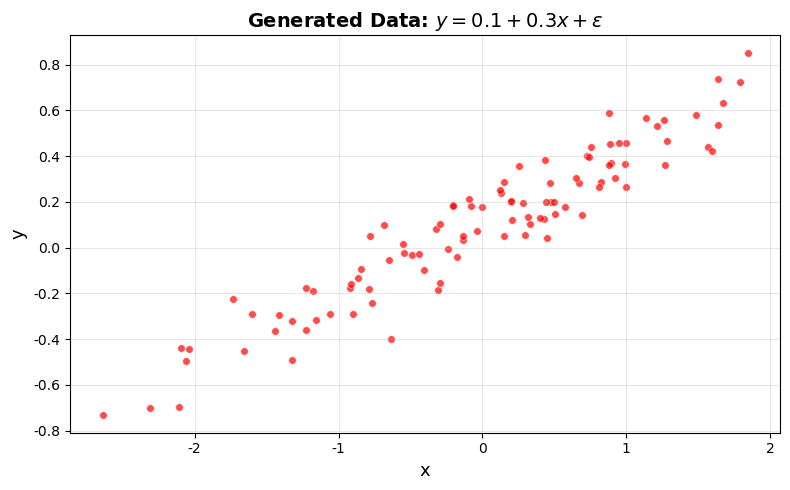

In [12]:
# 참값 (ground truth)
N  = 100       # 샘플 수
w0 = 0.1       # 절편
w1 = 0.3       # 기울기

# 데이터 생성
x = np.random.normal(0.0, 1, N).reshape(-1, 1)
y = w0 + w1 * x
y = y + np.random.normal(0.0, 0.1, N).reshape(-1, 1)

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")
print(f"참값: w₀ = {w0}, w₁ = {w1}")

# 데이터 시각화
plt.figure()
plt.scatter(x, y, c='r', s=30, alpha=0.7, edgecolors='white', linewidths=0.5)
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.title('Generated Data: $y = 0.1 + 0.3x + \\epsilon$', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
## Step 2: 정규방정식으로 풀기 (Least Square Method)

Augmented 행렬 $\mathbf{X}$를 구성하고, 정규방정식을 적용합니다.

$$\mathbf{X} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{bmatrix}, \qquad \mathbf{w}^* = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$


In [13]:
# Augmented 행렬 X 구성: [1, x]
X = np.hstack([x**0, x])
X = np.asmatrix(X)

# 정규방정식: w* = (XᵀX)⁻¹ Xᵀy
w_ls = np.array((X.T * X).I * X.T * y)

print(f"X shape: {X.shape}")
print(f"\n정규방정식 결과:")
print("=" * 40)
print(f"  w₀ (절편)  = {w_ls[0, 0]:.6f}  (참값: {w0})")
print(f"  w₁ (기울기) = {w_ls[1, 0]:.6f}  (참값: {w1})")
print("=" * 40)


X shape: (100, 2)

정규방정식 결과:
  w₀ (절편)  = 0.101913  (참값: 0.1)
  w₁ (기울기) = 0.305895  (참값: 0.3)


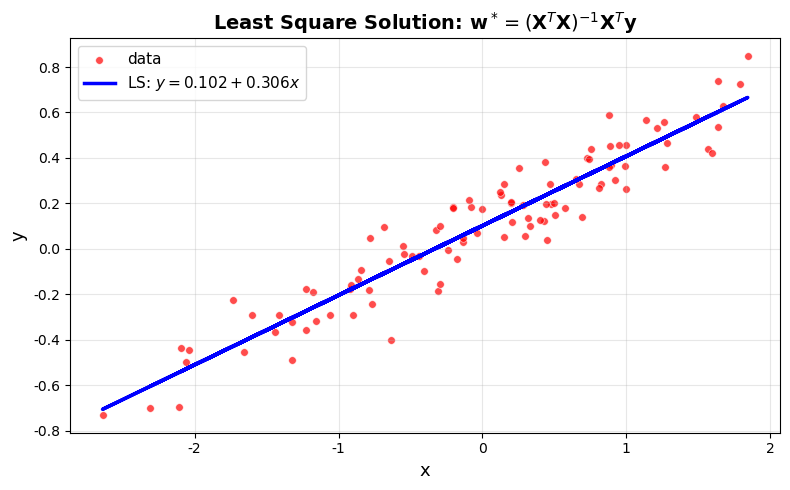

In [14]:
# 결과 시각화
plt.figure()
plt.scatter(x, y, c='r', s=30, alpha=0.7, edgecolors='white', linewidths=0.5, label='data')
plt.plot(x, w_ls[1, 0] * x + w_ls[0, 0], 'b-', linewidth=2.5,
         label=f'LS: $y = {w_ls[0,0]:.3f} + {w_ls[1,0]:.3f}x$')
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.title('Least Square Solution: $\\mathbf{w}^* = (\\mathbf{X}^T\\mathbf{X})^{-1}\\mathbf{X}^T \\mathbf{y}$',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
## Step 3: 경사하강법으로 풀기 (Gradient Descent Method)

$$\frac{\partial J}{\partial \mathbf{w}} = 2(\mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T \mathbf{y})$$

$$\mathbf{w} \leftarrow \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}$$


In [15]:
# 초기 파라미터 (랜덤)
w = np.random.randn(2, 1)
w = np.asmatrix(w)

# 하이퍼파라미터
alpha  = 0.00001     # step size
n_iter = 3000        # 반복 횟수
w_history = []

print(f"초기 w = ({w[0,0]:.4f}, {w[1,0]:.4f})")
print(f"step size α = {alpha}")
print(f"반복 횟수 = {n_iter}")
print()

# 경사하강법 반복
for i in range(n_iter):
    dJ = 2 * (X.T * X * w - X.T * y)    # ∂J/∂w = 2(XᵀXw - Xᵀy)
    w  = w - alpha * dJ                   # w ← w - α·∂J/∂w
    w_history.append(np.array(w)[:, 0])

    if i % 500 == 0 or i == n_iter - 1:
        residual = y - X * w
        loss = float(np.array(residual.T * residual))  # J = ‖Xw - y‖²
        print(f"iter={i:5d}  w₀={w[0,0]:+.6f}  w₁={w[1,0]:+.6f}  J={loss:.6f}")

print()
print("최종 결과:")
print("=" * 40)
print(f"  w₀ = {w[0,0]:.6f}  (참값: {w0})")
print(f"  w₁ = {w[1,0]:.6f}  (참값: {w1})")
print("=" * 40)


초기 w = (0.6805, 0.3144)
step size α = 1e-05
반복 횟수 = 3000

iter=    0  w₀=+0.679331  w₁=+0.314401  J=34.419397
iter=  500  w₀=+0.314249  w₁=+0.313665  J=5.600904
iter= 1000  w₀=+0.180035  w₁=+0.310363  J=1.704373
iter= 1500  w₀=+0.130669  w₁=+0.308097  J=1.176502
iter= 2000  w₀=+0.112503  w₁=+0.306899  J=1.104867
iter= 2500  w₀=+0.105815  w₁=+0.306332  J=1.095132
iter= 2999  w₀=+0.103354  w₁=+0.306080  J=1.093807

최종 결과:
  w₀ = 0.103354  (참값: 0.1)
  w₁ = 0.306080  (참값: 0.3)


C:\Users\User\AppData\Local\Temp\ipykernel_28228\2694590212.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss = float(np.array(residual.T * residual))  # J = ‖Xw - y‖²


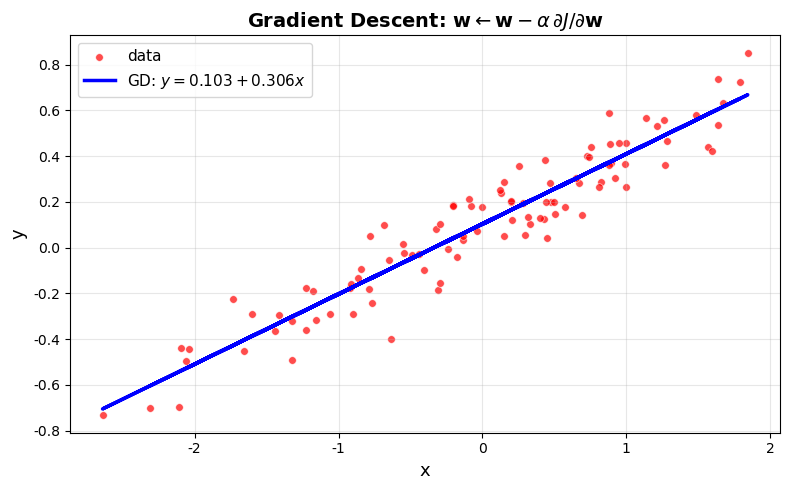

In [16]:
# 회귀 직선 시각화
plt.figure()
plt.scatter(x, y, c='r', s=30, alpha=0.7, edgecolors='white', linewidths=0.5, label='data')
plt.plot(x, float(w[1, 0]) * x + float(w[0, 0]), 'b-', linewidth=2.5,
         label=f'GD: $y = {float(w[0,0]):.3f} + {float(w[1,0]):.3f}x$')
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.title('Gradient Descent: $\\mathbf{w} \\leftarrow \\mathbf{w} - \\alpha \\, \\partial J / \\partial \\mathbf{w}$',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


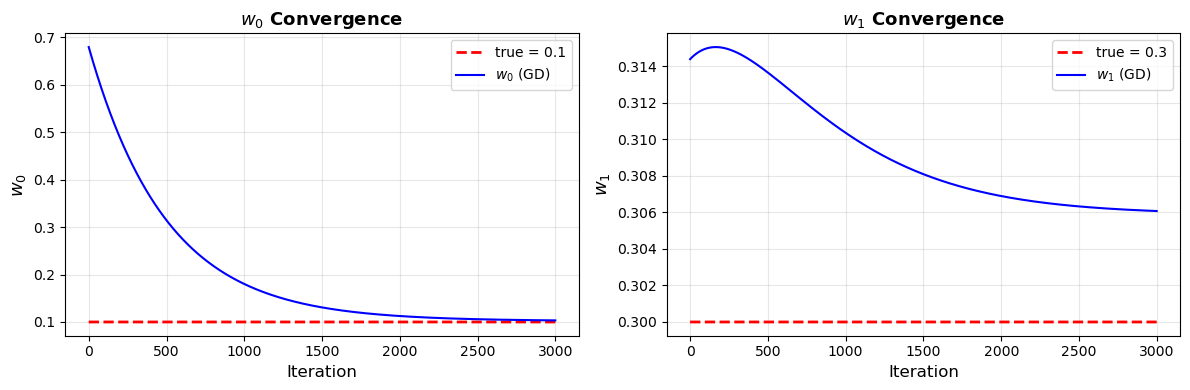

In [17]:
# w convergence
w_history = np.array(w_history)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# w₀ convergence
axes[0].plot(np.arange(n_iter), np.ones(n_iter) * w0,
             'r', linewidth=2, linestyle='--', label=f'true = {w0}')
axes[0].plot(w_history[:, 0], 'b', linewidth=1.5, label='$w_0$ (GD)')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('$w_0$', fontsize=13)
axes[0].set_title('$w_0$ Convergence', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# w₁ convergence
axes[1].plot(np.arange(n_iter), np.ones(n_iter) * w1,
             'r', linewidth=2, linestyle='--', label=f'true = {w1}')
axes[1].plot(w_history[:, 1], 'b', linewidth=1.5, label='$w_1$ (GD)')
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('$w_1$', fontsize=13)
axes[1].set_title('$w_1$ Convergence', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---
## 전체 과정 요약

| 단계 | 수식 | 설명 |
|:---|:---|:---|
| 데이터 | $y = 0.1 + 0.3x + \epsilon$ | $N=100$, $\epsilon \sim \mathcal{N}(0, 0.1)$ |
| Augmented 행렬 | $\mathbf{X} = [\mathbf{1},\, \mathbf{x}]$ | shape: $(N, 2)$ |
| Least Square | $\mathbf{w}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ | 해석적 해 (closed-form) |
| Gradient Descent | $\mathbf{w} \leftarrow \mathbf{w} - \alpha \cdot 2(\mathbf{X}^T\mathbf{X}\mathbf{w} - \mathbf{X}^T\mathbf{y})$ | 반복적 최적화 |


---
## 연습 문제

아래 셀에서 step size(`alpha`)나 반복 횟수(`n_iter`)를 변경해보고, 수렴 과정이 어떻게 달라지는지 확인해보세요.

1. `alpha = 0.0001`로 키우면 어떻게 되나요?
2. `n_iter = 100`으로 줄이면 수렴하나요?
3. 참값을 `w0 = 2.0`, `w1 = -0.5`로 바꾸고 처음부터 다시 해보세요.


In [18]:
# 여기에 코드를 작성하세요


